In [1]:
import collections
import os

import igraph as ig
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from tqdm import tqdm

plt.style.use("dark_background")

In [2]:
root_dir = ".."

In [3]:
admin = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
admin.geometry = admin.geometry.boundary
admin.geometry = admin.geometry.simplify(tolerance=0.1)

In [4]:
# read in global multi-modal transport network

network_dir = os.path.join(root_dir, "results/multi-modal_network/")
nodes = gpd.read_parquet(os.path.join(network_dir, "nodes.gpq"))
edges = gpd.read_parquet(os.path.join(network_dir, "edges.gpq"))

In [5]:
# read in trade OD matrix

od_dir = os.path.join(root_dir, "results/input/trade_matrix")
od = pd.read_parquet(os.path.join(od_dir, "trade_nodes_total.parquet"))

# only keep most significant pairs, drops number from ~21M -> ~2M
od = od[od.volume_tons > 5]

In [6]:
countries = od.partner_GID_0.unique()
source_nodes = od["id"].unique()
od

,id,THA_GID_1,partner_GID_0,value_kusd,volume_tons,GID_1
231,thailand-latest_14_1060,THA.10_1,ARE,5.958418,8.921528,THA.10_1
237,thailand-latest_14_1060,THA.10_1,AUS,10.831574,15.529106,THA.10_1
255,thailand-latest_14_1060,THA.10_1,BRA,8.044474,14.040133,THA.10_1
265,thailand-latest_14_1060,THA.10_1,CHN,85.528901,55.493995,THA.10_1
318,thailand-latest_14_1060,THA.10_1,IDN,9.702360,15.393054,THA.10_1
...,...,...,...,...,...,...
21430557,thailand-latest_43_125,THA.9_1,TWN,279.253313,112.164923,THA.9_1
21430560,thailand-latest_43_125,THA.9_1,UKR,40.033643,173.468912,THA.9_1
21430562,thailand-latest_43_125,THA.9_1,USA,746.706741,696.701952,THA.9_1
21430567,thailand-latest_43_125,THA.9_1,VNM,281.980553,180.195683,THA.9_1


In [7]:
# cannot add vertices as edges reference port493_out, port281_in, etc. which are missing from nodes file
# use_vids=False as edges.from_id and edges_to_id are not integers
graph = ig.Graph.DataFrame(edges, directed=True, use_vids=False)

(-24293562.312665932, 14986163.288426027)

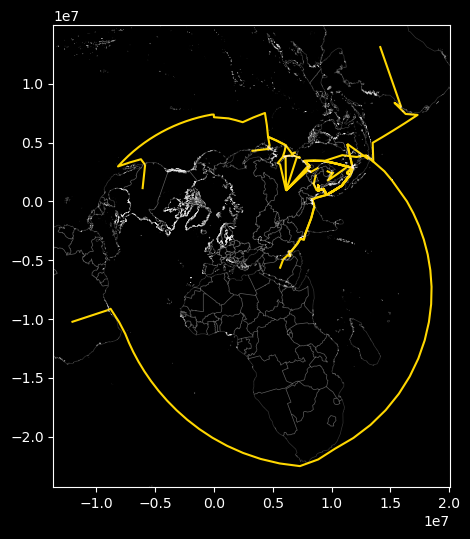

In [8]:
source_node = "thailand-latest_14_1060"
dest_nodes: list[str] = [f"GID_0_{ISO_A3}" for ISO_A3 in od[od["id"] == source_node].partner_GID_0.unique()]
edge_ids: list[list[int]] = graph.get_shortest_paths(f"road_{source_node}", dest_nodes, weights="cost_USD_t", output="epath")

f, ax = plt.subplots(figsize=(6, 6))
pd.concat([edges.iloc[ids] for ids in edge_ids]).to_crs(epsg=3995).plot(ax=ax, color="gold")
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
admin.to_crs(epsg=3995).plot(ax=ax, lw=0.5, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [9]:
# source_node -> destination country e.g. GID_0_GBR -> list of integer edge ids
routes: dict[str, dict[str, list[int]]] = {}

edges["value_kusd"] = 0
edges["volume_tons"] = 0
value_col_id = edges.columns.get_loc("value_kusd")
volume_col_id = edges.columns.get_loc("volume_tons")

for from_node in tqdm(od.id.unique()[:3]):
    from_node_od = od[od.id == from_node]
    dest_nodes = [f"GID_0_{iso_a3}" for iso_a3 in from_node_od.partner_GID_0.unique()]

    try:
        routes_edge_list: list[list[int]] = graph.get_shortest_paths(
            f"road_{from_node}",
            dest_nodes,
            weights="cost_USD_t",
            output="epath"
        )
    except ValueError as error:
        if "no such vertex" in str(error):
            print(error)
            print("... skipping destination")
            continue

    # store routes
    routes[from_node] = dict(zip(dest_nodes, routes_edge_list))
    
    for dest_node, route_edge_ids in routes[from_node].items():

        # lookup trade value and volume for each pairing of from_node and partner country
        # GID_0_GBR -> GBR
        iso_a3 = dest_node.split("_")[-1]
        route = od[(od.id == from_node) & (od.partner_GID_0 == iso_a3)]
        value_kusd, = route.value_kusd
        volume_tons, = route.volume_tons

        # increment edges with flows
        edges.iloc[route_edge_ids, value_col_id] += value_kusd
        edges.iloc[route_edge_ids, volume_col_id] += volume_tons

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.03s/it]


(-25147693.910860356, 32922926.850508925)

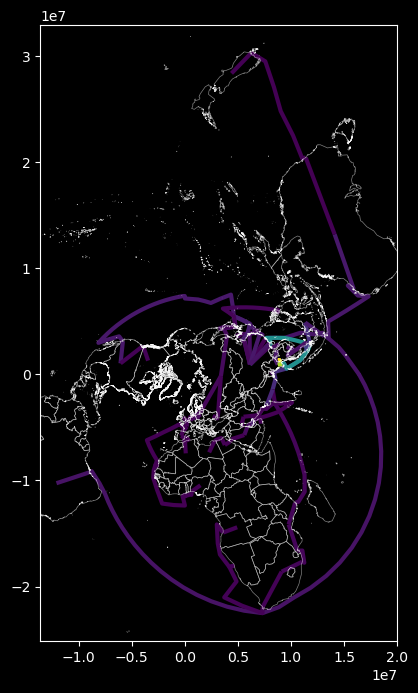

In [10]:
f, ax = plt.subplots(figsize=(8, 8))
edges[edges["volume_tons"] != 0].to_crs(epsg=3995).plot(
    "volume_tons",
    ax=ax,
    lw=3
)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
admin.to_crs(epsg=3995).plot(ax=ax, lw=0.5, alpha=0.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)